# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [4]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import graphviz 
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier

from scipy.stats import zscore



# import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)


Using device: cpu


In [5]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [6]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

## Pivoting Frequency values to columns

In [7]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [99]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/'
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test'

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df.head()

# Find if value samples have '_' in the name and remove everything after '_' 

df['Sample'] = df['Sample'].str.split('_').str[0]



df.head(10)


,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,-0.274692,28.903674,B1
1,100.0,-0.152607,29.605664,B1
2,100.0,0.549383,28.567940,B1
3,100.0,0.000000,30.155048,B1
4,100.0,-1.037724,30.216090,B1
5,100.0,0.732511,24.874862,B1
6,100.0,0.000000,29.422536,B1
7,100.0,-0.305213,30.155048,B1
8,100.0,0.091564,31.192772,B1
9,100.0,0.335734,27.713344,B1


## Balance Dataset

C:\Users\Danim\AppData\Local\Temp\ipykernel_35180\1209927551.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


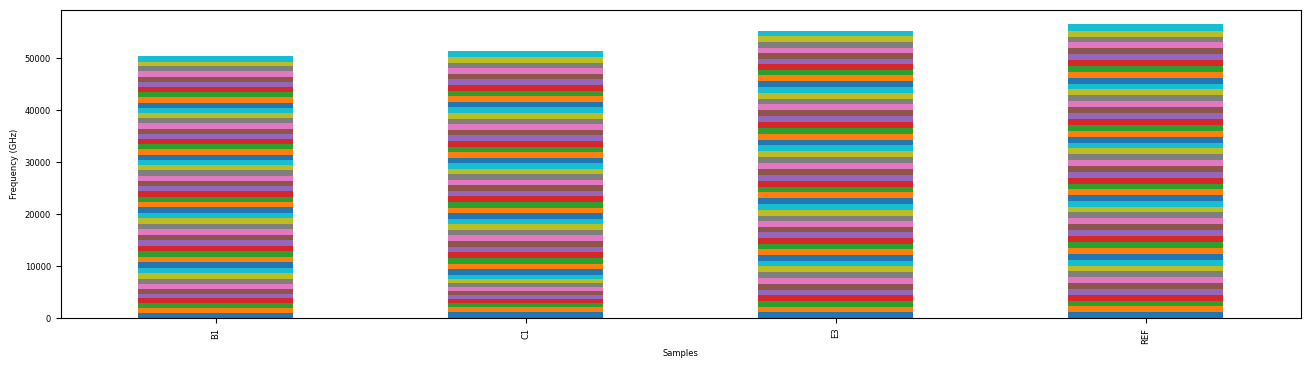

Mode value: 1132


C:\Users\Danim\AppData\Local\Temp\ipykernel_35180\1209927551.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


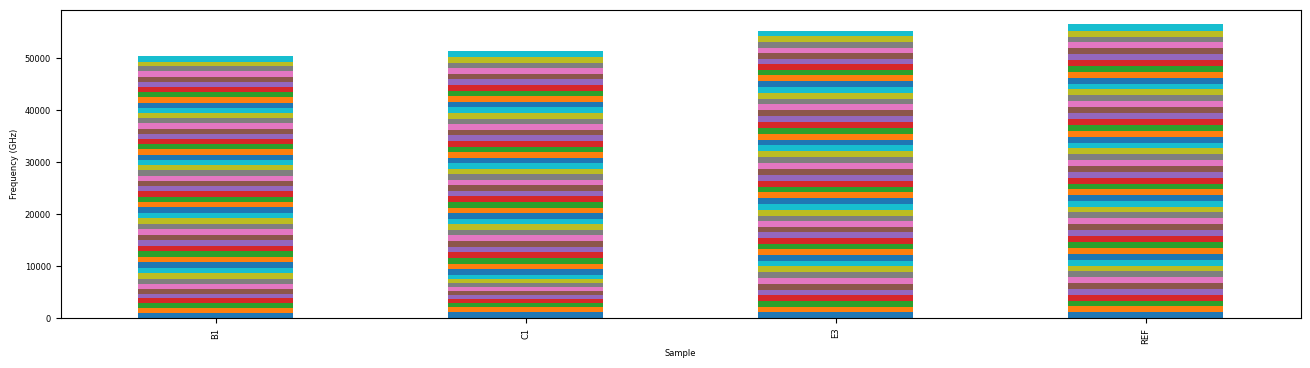

In [100]:
# Number of samples per frequency and Sample
bx = df.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_xlabel('Samples')
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
#no legend
bx.get_legend().remove()
plt.show()

# Balance the data by taking the mode of samples per frequency
mode = df.groupby(['Sample', 'Frequency (GHz)']).size().mode()[0]
print(f'Mode value: {mode}')
mode = 2350

# Function to reduce samples to the mode value
def reduce_to_mode(df, sample, frequency, mode):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mode, sample down to the mode
    if len(freq_df) > mode:
        return freq_df.sample(n=mode, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mode(df, sample, frequency, mode))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)

bx = df_balanced.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
# legend small
bx.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#remove legend
bx.get_legend().remove()
plt.show()

## Sample a test set

In [ ]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
test_percentage = 0.25
# train_set, test_set = train_test_split(df, test_size=test_percentage, random_state=42) 
# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42)
train_set, test_set = train_test_split(df_balanced, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set




,Frequency (GHz),LG (mV),HG (mV),Sample
159627,140.0,82.956903,-0.640935,REF
177212,470.0,1.007203,105.176425,REF
1439,120.0,46.880723,-0.427294,B1
114021,330.0,0.427298,473.812747,E3
51269,110.0,57.380050,0.518841,C1


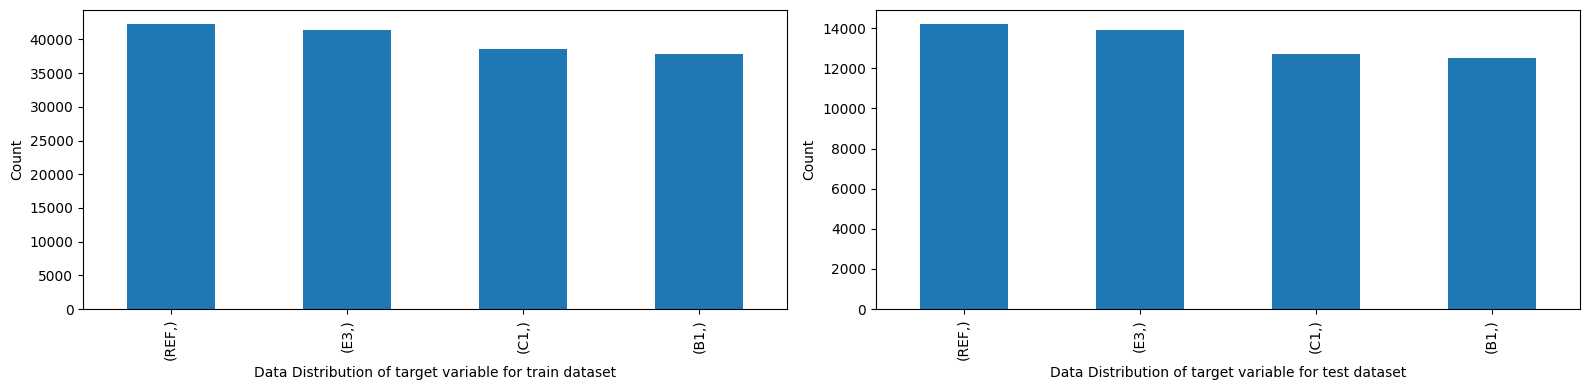

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [13]:
train_ex = train_set.copy()

In [14]:
train_ex.info()
# train_ex.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 160008 entries, 37351 to 117182
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Frequency (GHz)  160008 non-null  float64
 1   LG (mV)          160008 non-null  float64
 2   HG (mV)          160008 non-null  float64
 3   Sample           160008 non-null  object 
dtypes: float64(3), object(1)
memory usage: 6.1+ MB


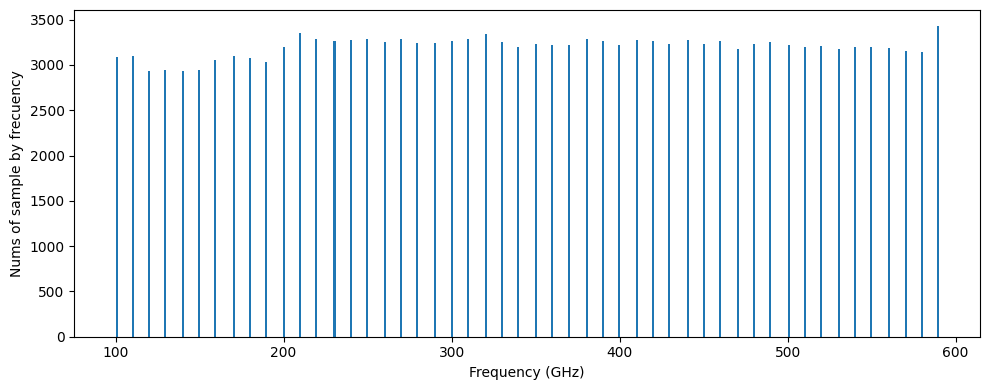

In [15]:
ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
# ax = test_set['Frequency (GHz)'].plot.hist(ax=ax, bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

In [124]:
# Calculate the percentage of data used for each window
time_window_s = 1
stabilised_time_s = 24
data_percentage = (100/(stabilised_time_s*(1-test_percentage)))*time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage)))*time_window_s

# data_percentage = 100
# data_percentage_test = 100

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)


# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)


# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

# #Save the processed data to a CSV file

# output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)





Data percentage: 5.555555555555555%
Data percentage test: 16.666666666666668%


# Prepare Training Data
## Split the data into X and y


In [102]:
def preprocess_data(df, labels, freqs, eliminate_std_dev=False):
    # Reduce number of different samples for testing
    X_ = df[df['Sample'].isin(labels)]

    y_ = X_['Sample']

    X_ = X_.drop(columns=['Sample'])

    if freqs:
        # Subset of specific frequencies to use as input features (or without mean)
        columns = [f'{freq}.0 HG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 HG (mV)' for freq in freqs] + \
                  [f'{freq}.0 LG (mV)' for freq in freqs] + \
                  [f'{freq}.0 HG (mV) std deviation' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) std deviation' for freq in freqs] 


        # Filter columns that exist in X_
        existing_columns = [col for col in columns if col in X_.columns]

        # Check if existing_columns is empty
        if not existing_columns:
            print("No matching columns found in X_.")
        else:
            X_ = X_[existing_columns]

        # Sort columns by frequency value
        X_ = X_.reindex(sorted(X_.columns), axis=1)

    if eliminate_std_dev:
        # Eliminate std dev columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'std deviation' in col])

    return X_, y_


In [125]:
# Subset of specific Samples to use in the training
# labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']
labels = ['B1', 'C1', 'E3', 'REF']

# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360]
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360,340,350,370,380,390,400,410,430,440]
freqs = [250,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500]


freqs = []



# # Shuffle the data
# train_set_test = train_set_test.sample(frac=1, random_state=42)
# test_set_test = test_set_test.sample(frac=1, random_state=42)



X_train, y_train = preprocess_data(train_set_test, labels, freqs, eliminate_std_dev=False) 
X_test, y_test = preprocess_data(test_set_test, labels, freqs, eliminate_std_dev=False)

# Encode the target variable if it's categorical
if y_train.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

if y_test.dtype == 'object':
    y_test = le.transform(y_test)


# le is the fitted LabelEncoder - Saving Encoder
joblib.dump(le, 'label_encoder.pkl')


# # Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)






['label_encoder.pkl']

In [104]:
#### CHECK ####
# FEATURE TRANSFORMATIONS
# feature engineering transformation with autofeat
from autofeat import AutoFeatClassifier
from autofeat import AutoFeatRegressor

# Initialize the autofeat transformer

# Separate features and target
target_column = 'Material'  # Adjust if different
X_train = train_set_test.drop(columns=[target_column])
y_train = train_set_test[target_column]
X_test = test_set_test.drop(columns=[target_column])
y_test = test_set_test[target_column]

# Initialize AutoFeatRegressor
af = AutoFeatRegressor(
    verbose=1,  # Show progress
    feateng_steps=2,  # Number of feature engineering steps
    max_features_to_select=50,  # Max number of engineered features
    random_state=42
)

# Fit and transform training data
print("Fitting AutoFeat on training data...")
X_train_feat = af.fit_transform(X_train, y_train)

# Transform test data
print("Transforming test data...")
X_test_feat = af.transform(X_test)

# Create new dataframes with engineered features
train_set_engineered = pd.concat([pd.DataFrame(X_train_feat, columns=af.feature_names_, index=X_train.index), 
                                y_train], axis=1)
test_set_engineered = pd.concat([pd.DataFrame(X_test_feat, columns=af.feature_names_, index=X_test.index), 
                               y_test], axis=1)

print(f"Original features: {X_train.shape[1]}")
print(f"Engineered features: {X_train_feat.shape[1]}")

# Optional: Save engineered datasets
# train_set_engineered.to_csv('train_set_engineered.csv', sep=';', index=False)
# test_set_engineered.to_csv('test_set_engineered.csv', sep=';', index=False)


KeyError: "['Material'] not found in axis"

### Principal Component Analysis

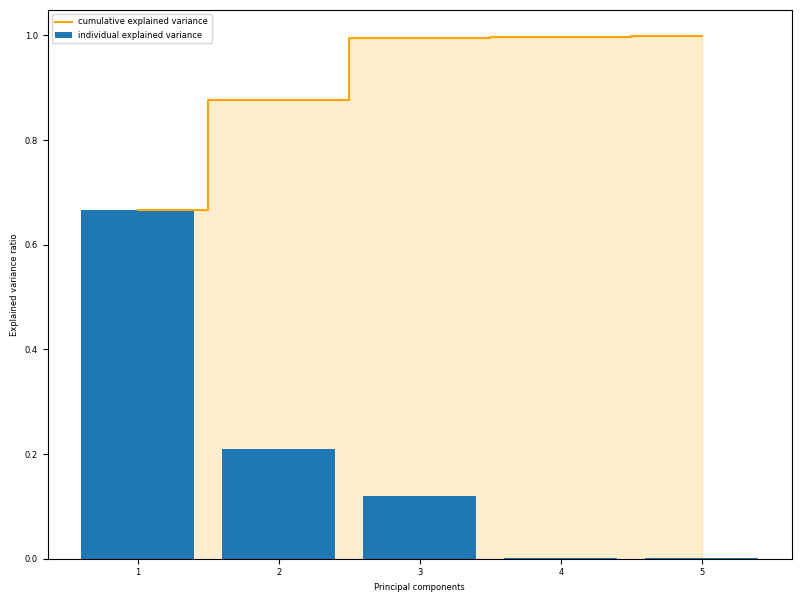

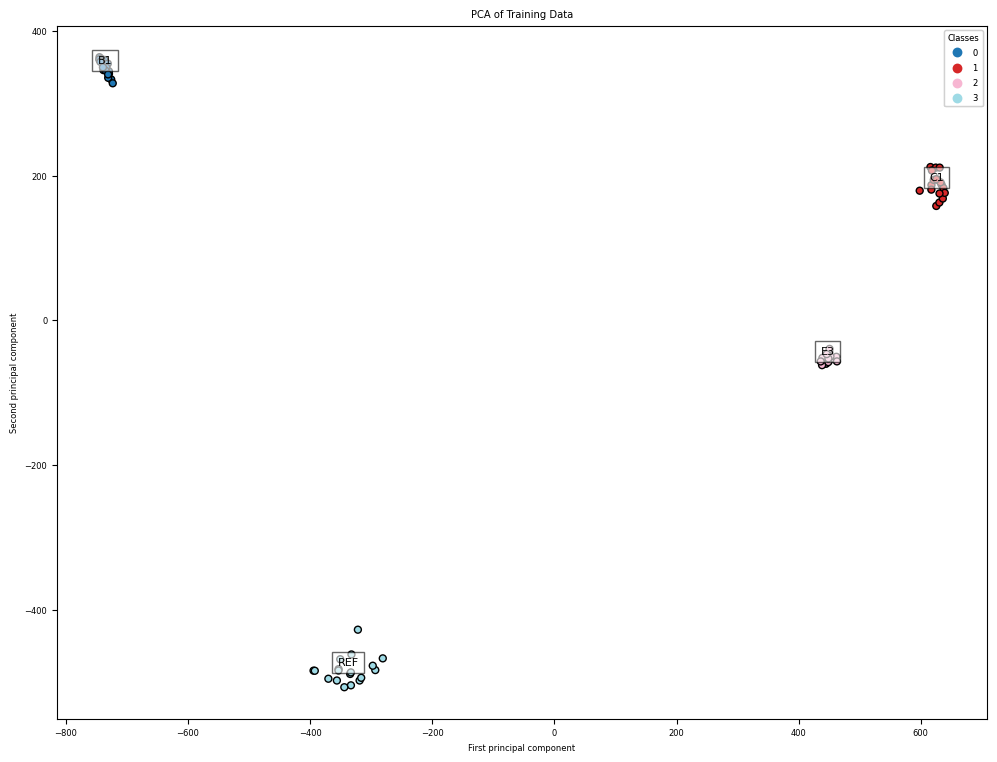

Component 1:
250.0 HG (mV) mean             0.662287
340.0 HG (mV) mean             0.501154
320.0 HG (mV) mean             0.341516
330.0 HG (mV) mean             0.175928
230.0 HG (mV) std deviation    0.102831
300.0 HG (mV) mean             0.083720
300.0 HG (mV) std deviation    0.082245
250.0 HG (mV) std deviation    0.035392
100.0 LG (mV) std deviation    0.026141
100.0 LG (mV) mean             0.025352
Name: 0, dtype: float64 

390.0 HG (mV) mean            -0.228838
350.0 HG (mV) mean            -0.131294
380.0 HG (mV) mean            -0.101901
370.0 HG (mV) mean            -0.096551
340.0 HG (mV) std deviation   -0.086855
420.0 HG (mV) mean            -0.083592
360.0 HG (mV) mean            -0.081189
230.0 HG (mV) mean            -0.070856
400.0 HG (mV) mean            -0.053235
450.0 HG (mV) mean            -0.052629
Name: 0, dtype: float64 

Component 2:
330.0 HG (mV) mean             0.607634
230.0 HG (mV) mean             0.231163
320.0 HG (mV) std deviation    0.084751
37

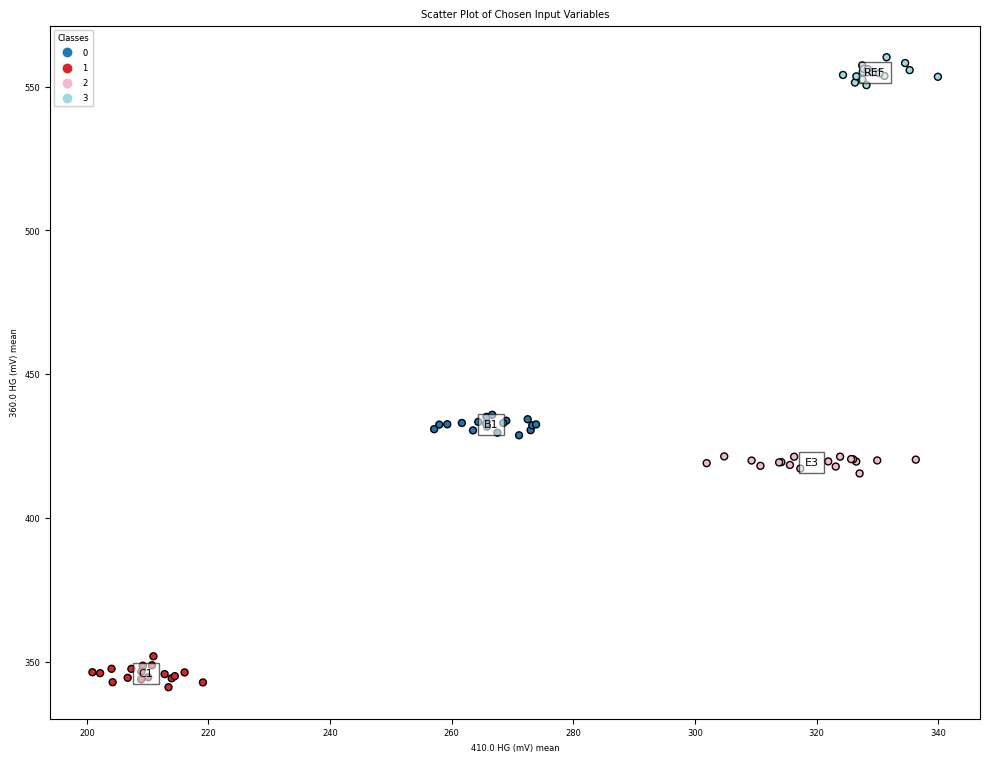

In [126]:
# Apply PCA
n_components = 5
pca = PCA(n_components)  # Reduce to 2 components for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_pca = y_train

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.step(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance', color='orange')
plt.fill_between(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), step='mid', alpha=0.2, color='orange')
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_, alpha=1.0, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### VISUALIZATION ###
# Plot the PCA components (first two components for visualization)
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_pca, cmap = 'tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 10
for i, label in enumerate(labels):
    plt.text(X_train_pca[y_pca == i, 0].mean() , X_train_pca[y_pca == i, 1].mean() + offset, label,
             ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))


plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA of Training Data')


plt.show()


# Show how the principal components are related to the original features
# Create a DataFrame with the PCA components
components = pd.DataFrame(pca.components_, columns=X_train.columns)
# Transpose the DataFrame
components = components.T
# Display the highest and lowest n variables of the first 3 components
n= 10
for i in range(n_components):
    print(f"Component {i+1}:")
    print(components[i].nlargest(n), '\n')
    print(components[i].nsmallest(n), '\n')


## NON PCA VISUALIZATION ##
# Choose specific variables for visualization
var1 = '410.0 HG (mV)'
var2 = '360.0 HG (mV)'
# var2 = '320.0 HG (mV) std deviation'

try:
    X_train[var1].describe()
except Exception as e:
    var1 = f'{var1} mean'
    var2 = f'{var2} mean'

# Plot the chosen input variables for visualization
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train[var1], X_train[var2], c=y_train, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0
unique_labels = np.unique(y_train)
for i, label in enumerate(unique_labels):
    plt.text(X_train[y_train == label][var1].mean(), X_train[y_train == label][var2].mean() + offset, 
             labels[label], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))

plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Scatter Plot of Chosen Input Variables')

plt.show()



In [90]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

input_size, output_size

# print(f'input_size: {input_size}, output_size: {output_size}')
# print(X_train, y_train)

(200, 4)

### Random Forest Model

In [91]:
def random_forest_model(X_train, y_train, seed):
    # Define Random Forest model with parameters to reduce overfitting
    rf_model = RandomForestClassifier(
        n_estimators=10,  # Increase the number of trees
        criterion='gini',
        max_depth=3,  # Limit the maximum depth of the trees
        min_samples_split=5,  # Minimum number of samples required to split an internal node
        min_samples_leaf=2,  # Minimum number of samples required to be at a leaf node
        bootstrap=True,  # Use bootstrap sampling
        random_state=seed
    )
    # Train the model
    rf_model.fit(X_train, y_train)
    return rf_model

In [ ]:
def gradient_boosting_model(X_train, y_train, seed):
    # Define Gradient Boosting model
    gb_model = GradientBoostingClassifier(n_estimators=10, random_state=seed)
    # Train the model
    gb_model.fit(X_train, y_train)
    return gb_model

### Define Naive-Bayes model


In [32]:
def naive_bayes_model(X_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    return nb_model

### Logistic Regression

In [33]:
def logistic_regression_model(X_train, y_train, seed):
    lr_model = LogisticRegression(max_iter=10000, random_state=seed)
    lr_model.fit(X_train, y_train)
    return lr_model

In [36]:
# Function to apply confidence threshold
def apply_confidence_threshold(probabilities, threshold=0.5):
    max_probs = np.max(probabilities, axis=1)
    predictions = np.argmax(probabilities, axis=1)
    # Replace predictions with -1 (unknown) where confidence is below threshold
    predictions[max_probs < threshold] = -1
    return predictions, max_probs


Model 1 - Accuracy: 1.0
Model 1 - Precision: 1.0
Model 1 - Recall: 1.0
Model 1 - F1: 1.0
Model 1 - Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24
 

Model 1 - Predictions Counter:
 Counter({1: 6, 2: 6, 0: 6, 3: 6}) 

Model 2 - Accuracy: 1.0
Model 2 - Precision: 1.0
Model 2 - Recall: 1.0
Model 2 - F1: 1.0
Model 2 - Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.0

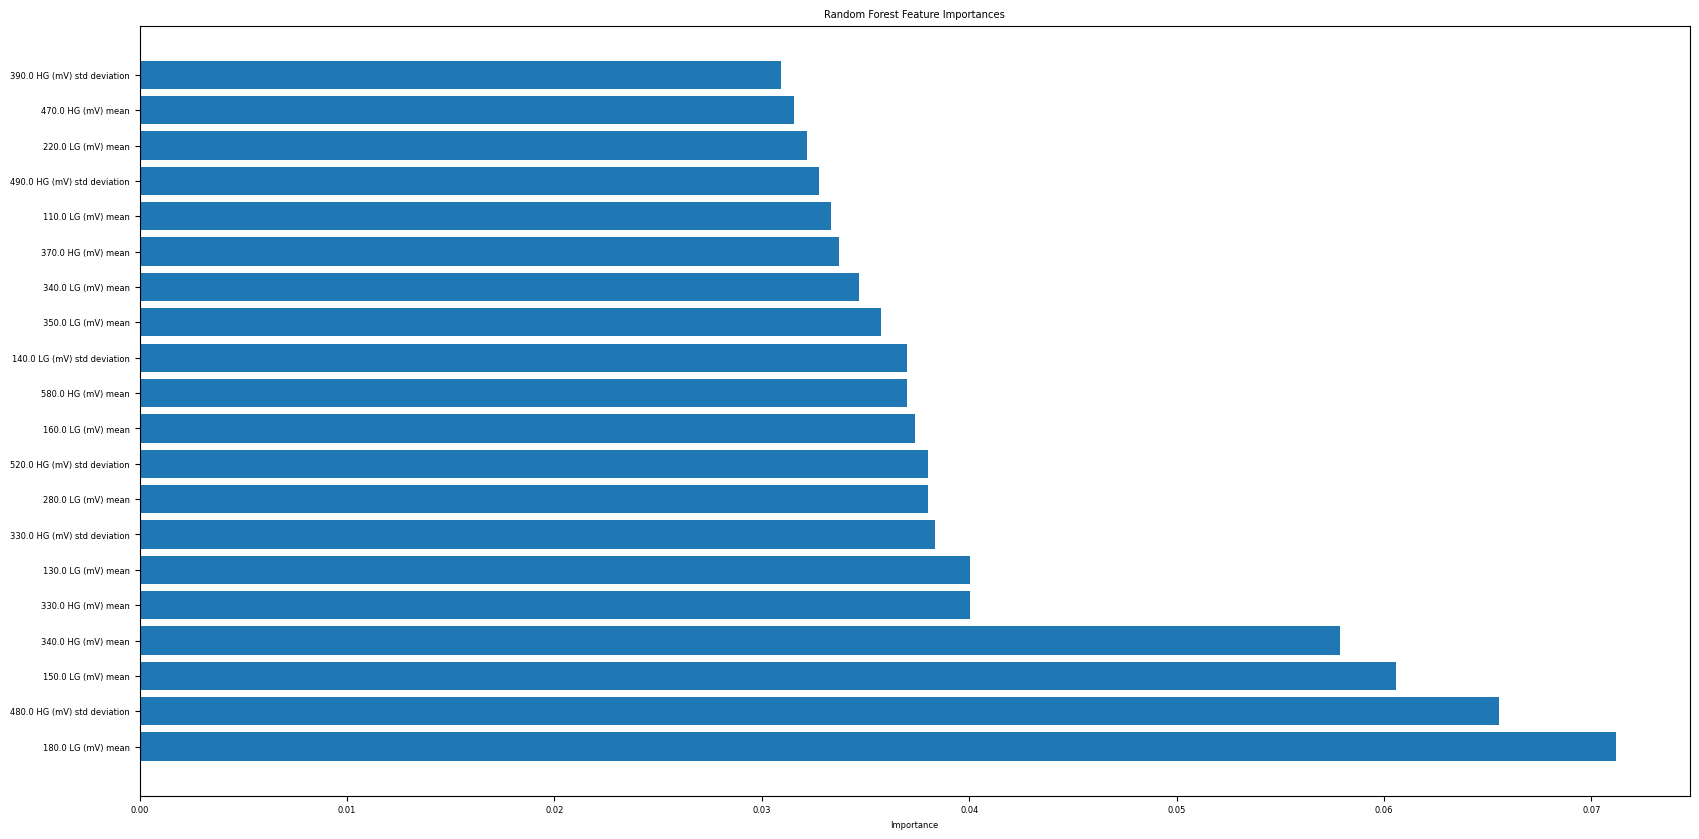

In [92]:
### Train models ###
rf_model = random_forest_model(X_train, y_train, seed)
nb_model = naive_bayes_model(X_train, y_train)
lr_model = logistic_regression_model(X_train, y_train, seed)

# Predictions
y_pred = []
y_pred.append(rf_model.predict(X_test))
y_pred.append(nb_model.predict(X_test))
y_pred.append(lr_model.predict(X_test))

# Save the model
# joblib.dump(rf_model, 'random_forest_model.pkl')
# joblib.dump(nb_model, 'naive_bayes_model.pkl')
# joblib.dump(lr_model, 'logistic_regression_model.pkl')

# Calculate metrics
for i, y_pred_i in enumerate(y_pred):
    accuracy = accuracy_score(y_test, y_pred_i)
    precision = precision_score(y_test, y_pred_i, average='weighted')
    recall = recall_score(y_test, y_pred_i, average='weighted')
    f1 = f1_score(y_test, y_pred_i, average='weighted')

    print(f"Model {i+1} - Accuracy: {accuracy}")
    print(f"Model {i+1} - Precision: {precision}")
    print(f"Model {i+1} - Recall: {recall}")
    print(f"Model {i+1} - F1: {f1}")

    # Classification report
    print(f"Model {i+1} - Classification Report:\n", classification_report(y_test, y_pred_i), '\n')

    # Predictions made per class with its label encoded value
    print(f"Model {i+1} - Predictions Counter:\n", Counter(y_pred_i), '\n')

# Feature importance (Find 10 most important variables with its name and importance value)
rf_feature_importances = rf_model.feature_importances_
# lr_feature_importances = lr_model.coef_[0]

feature_names = X_train.columns
rf_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_feature_importances})
# lr_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': lr_feature_importances})

rf_feature_importances_df = rf_feature_importances_df.sort_values('Importance', ascending=False)
# lr_feature_importances_df = lr_feature_importances_df.sort_values('Importance', ascending=False)

# Font size
plt.rcParams.update({'font.size': 6})



# Plot the feature importances
n = 20
print("Random Forest Feature Importances:\n", rf_feature_importances_df.head(n))


plt.figure(figsize=(20, 10))
plt.barh(rf_feature_importances_df['Feature'][:n], rf_feature_importances_df['Importance'][:n])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()



# print("Logistic Regression Feature Importances:\n", lr_feature_importances_df.head(204))
# plt.figure(figsize=(20, 10))
# plt.barh(lr_feature_importances_df['Feature'][:n], lr_feature_importances_df['Importance'][:n])
# plt.xlabel('Importance')
# plt.title('Logistic Regression Feature Importances')
# plt.show()

# # sum all the importances of LR
# print(lr_feature_importances_df['Importance'].sum())


## Threshold for Unknown class


Results with confidence threshold = 0.5
--------------------------------------------------

Random Forest:
Samples retained: 24/24 (100.0%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


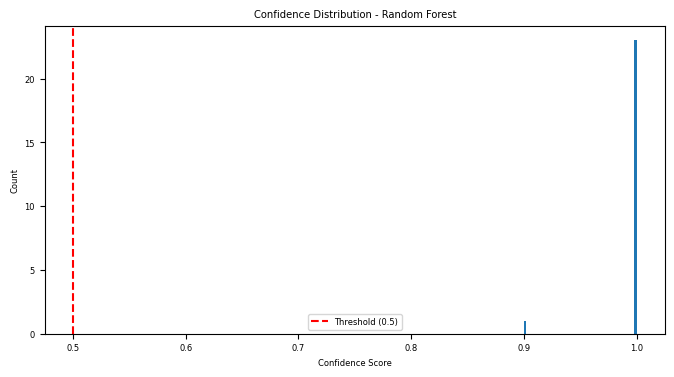


Naive Bayes:
Samples retained: 24/24 (100.0%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


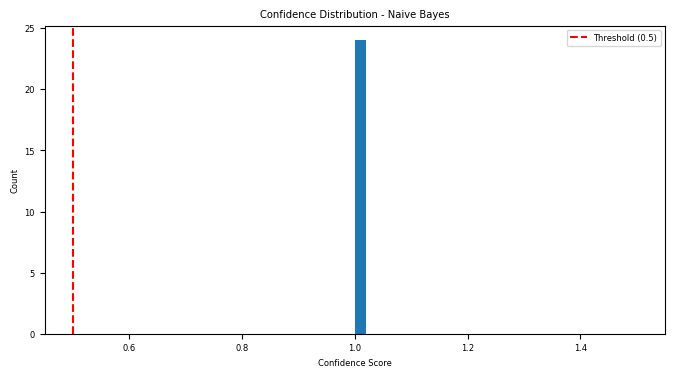


Logistic Regression:
Samples retained: 24/24 (100.0%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


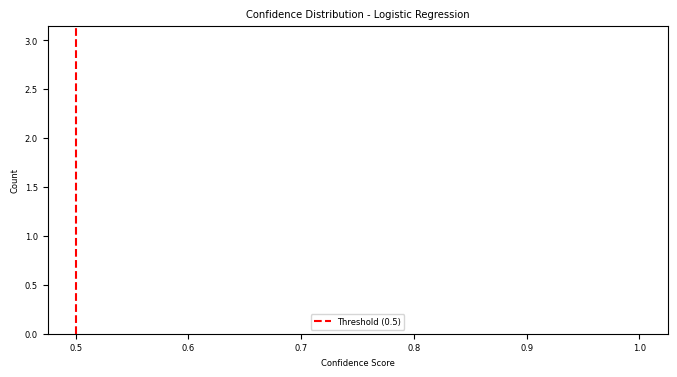


Results with confidence threshold = 0.7
--------------------------------------------------

Random Forest:
Samples retained: 24/24 (100.0%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


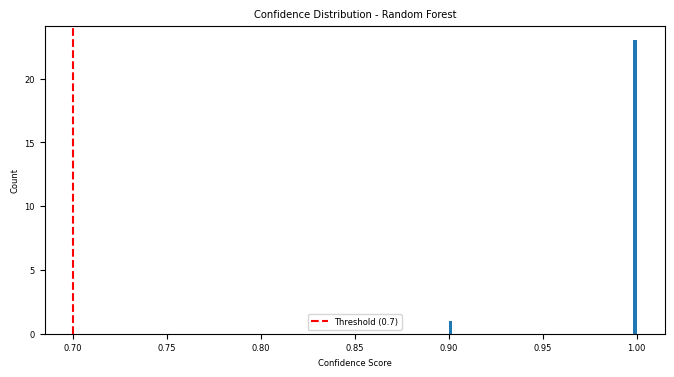


Naive Bayes:
Samples retained: 24/24 (100.0%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


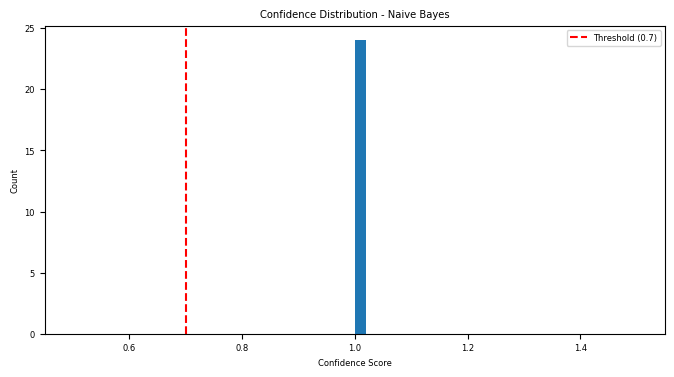


Logistic Regression:
Samples retained: 24/24 (100.0%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


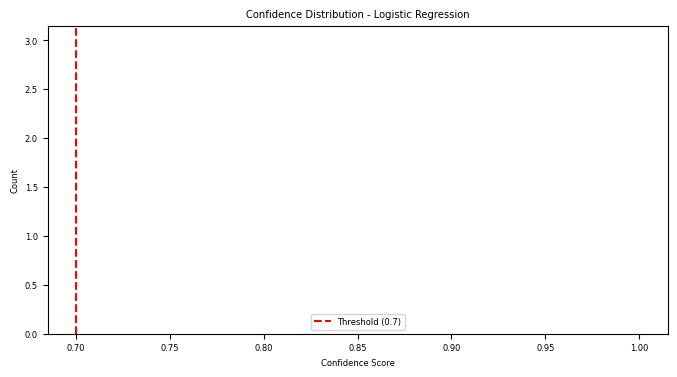


Results with confidence threshold = 0.9
--------------------------------------------------

Random Forest:
Samples retained: 24/24 (100.0%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


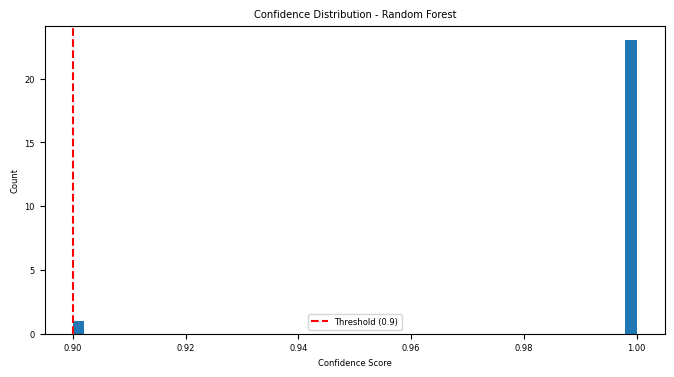


Naive Bayes:
Samples retained: 24/24 (100.0%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


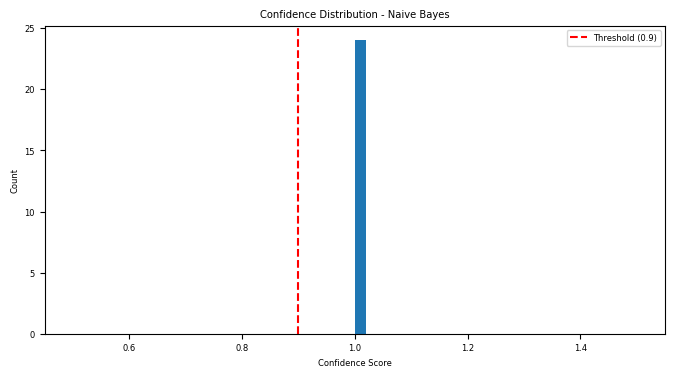


Logistic Regression:
Samples retained: 24/24 (100.0%)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


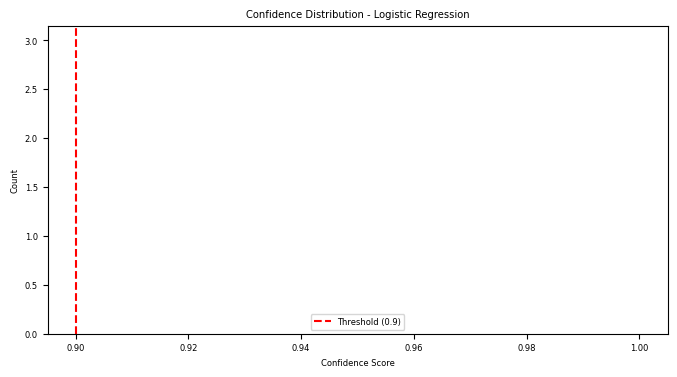

[[0.  1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.9 0.  0.1 0. ]
 [0.  0.  0.  1. ]
 [0.  1.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0. ]
 [1.  0.  0.  0. ]
 [0.  0.  0.  1. ]
 [1.  0.  0.  0. ]
 [1.  0.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  1.  0. ]
 [1.  0.  0.  0. ]
 [1.  0.  0.  0. ]
 [0.  0.  0.  1. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]
 [0.  0.  0.  1. ]
 [0.  1.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]
 [0.  1.  0.  0. ]]


In [79]:
# Get predictions and probabilities
rf_probs = rf_model.predict_proba(X_test)
nb_probs = nb_model.predict_proba(X_test)
lr_probs = lr_model.predict_proba(X_test)


# Apply thresholding
thresholds = [0.5, 0.7, 0.9]
models = ['Random Forest', 'Naive Bayes', 'Logistic Regression']
prob_list = [rf_probs, nb_probs, lr_probs]

for threshold in thresholds:
    print(f"\nResults with confidence threshold = {threshold}")
    print("-" * 50)
    
    for model_name, probs in zip(models, prob_list):
        predictions, confidences = apply_confidence_threshold(probs, threshold)
        
        # Convert -1 to 'unknown' for metrics
        valid_mask = predictions != -1
        
        if np.any(valid_mask):
            # Calculate metrics only on predictions above threshold
            accuracy = accuracy_score(y_test[valid_mask], predictions[valid_mask])
            precision = precision_score(y_test[valid_mask], predictions[valid_mask], 
                                     average='weighted')
            recall = recall_score(y_test[valid_mask], predictions[valid_mask], 
                                average='weighted')
            
            print(f"\n{model_name}:")
            print(f"Samples retained: {sum(valid_mask)}/{len(predictions)} "
                  f"({100*sum(valid_mask)/len(predictions):.1f}%)")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            
            # Plot confidence distribution
            plt.figure(figsize=(8, 4))
            plt.hist(confidences, bins=50)
            plt.axvline(x=threshold, color='r', linestyle='--', 
                       label=f'Threshold ({threshold})')
            plt.title(f'Confidence Distribution - {model_name}')
            plt.xlabel('Confidence Score')
            plt.ylabel('Count')
            plt.legend()
            plt.show()

print(rf_probs)

### Permutation Feature Importance

C:\Users\Danim\AppData\Local\Temp\ipykernel_35180\3995820570.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])


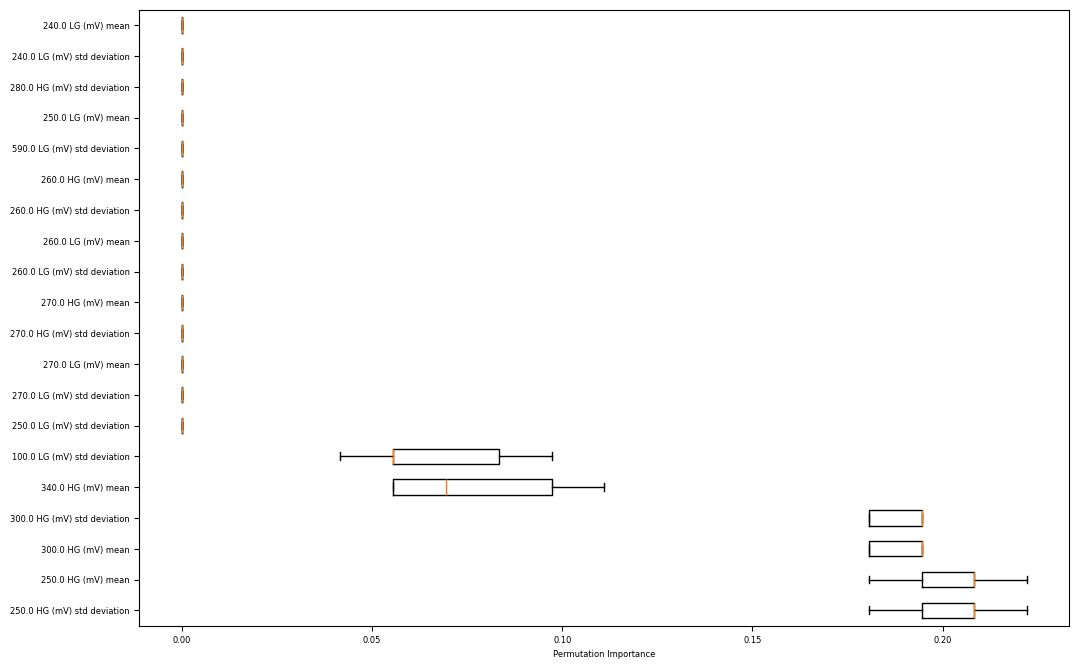

Permutation Importance:

250.0 HG (mV) std deviation: 0.2028
250.0 HG (mV) mean: 0.2028
300.0 HG (mV) mean: 0.1889
300.0 HG (mV) std deviation: 0.1889
340.0 HG (mV) mean: 0.0778
100.0 LG (mV) std deviation: 0.0667
250.0 LG (mV) std deviation: 0.0000
270.0 LG (mV) std deviation: 0.0000
270.0 LG (mV) mean: 0.0000
270.0 HG (mV) std deviation: 0.0000
270.0 HG (mV) mean: 0.0000
260.0 LG (mV) std deviation: 0.0000
260.0 LG (mV) mean: 0.0000
260.0 HG (mV) std deviation: 0.0000
260.0 HG (mV) mean: 0.0000
590.0 LG (mV) std deviation: 0.0000
250.0 LG (mV) mean: 0.0000
280.0 HG (mV) std deviation: 0.0000
240.0 LG (mV) std deviation: 0.0000
240.0 LG (mV) mean: 0.0000


In [93]:
result = permutation_importance(nb_model, X_train, y_train, n_repeats=5, random_state=seed, n_jobs=8)

# Preserve n most important features
n = 20
sorted_idx = result.importances_mean.argsort()[::-1][:n]  # Sort indices in descending order

plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

# Print n most important features from highest to lowest with their values
print("Permutation Importance:\n")
for i in sorted_idx:
    print(f"{X_train.columns[i]}: {result.importances_mean[i]:.4f}")


In [75]:
# Export Random Forest model with graphviz
feature_names = X_train.columns.tolist()  # Replace with your actual feature names

# Export the first tree in the Random Forest
dot_data = export_graphviz(
    rf_model.estimators_[0], 
    out_file=None, 
    filled=True, 
    rounded=True, 
    special_characters=True,
    feature_names=feature_names
)

# Create a graph from the dot data
graph = graphviz.Source(dot_data)

# Render the graph to a file
graph.render('random_forest_model')


'random_forest_model.pdf'

## Confusion Matrix

In [94]:
# # Confusion matrix with matplotlib

def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=9,
                     ha='center', va='center', color='white')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.title('Confusion Matrix')
    plt.show()


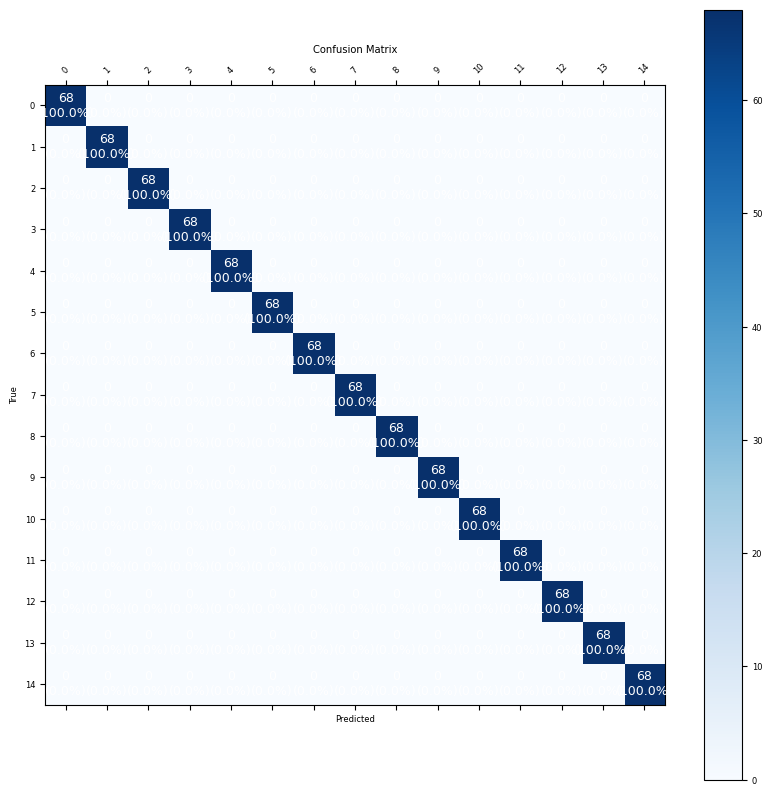

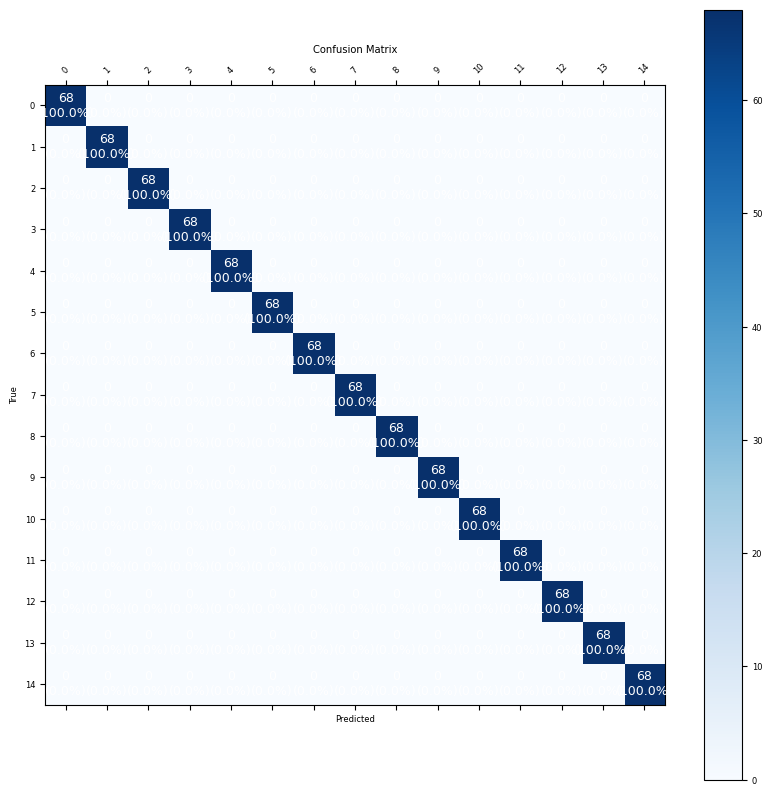

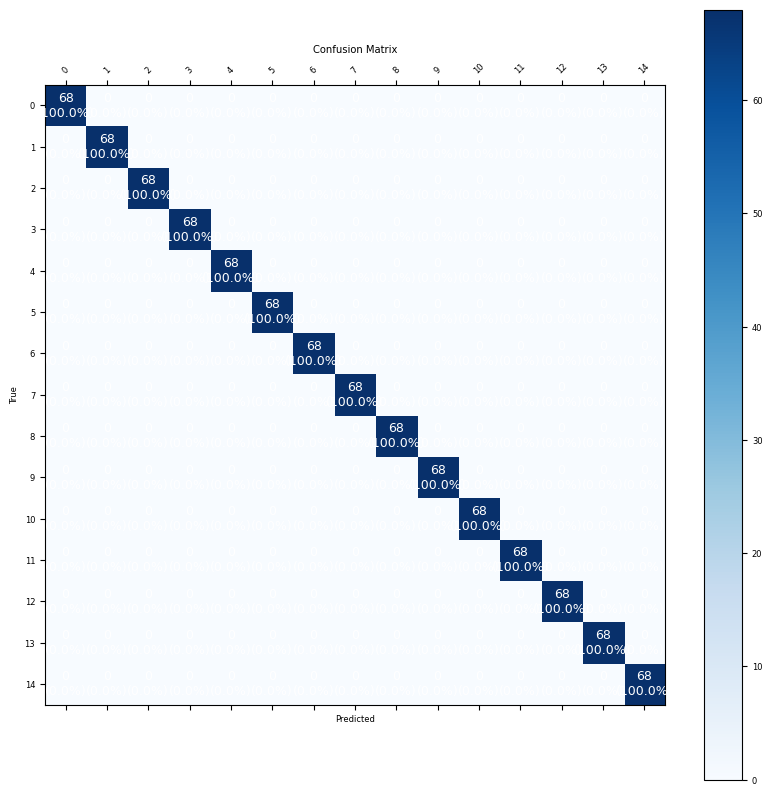

In [56]:
plot_confusion_matrix(y_test, y_pred[0], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[1], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[2], np.unique(y_test))

## Load and preprocess Other Test Data (Experiment 2)
Prepare new sample for testing (Testing other samples, out of initial dataset)

In [95]:
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'

df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)


# Time window
time_window_s = 1
sample_time_s = 14 * 6
data_percentage = (100/sample_time_s)*time_window_s
print(f"Data percentage: {data_percentage}%")

# data_percentage = 0

# Introduce Frequency values as input variables
df_new_sample = freq_as_variable(df_new_sample, data_percentage) # 0.22

# Subset of specific Samples to use in the training
# labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']
# labels = [ 'B1', 'C1', 'E1', 'REF']
labels = df_new_sample['Sample'].unique()

# freqs = []
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360]
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360,340,350,370,380,390,400,410,430,440]
# freqs = [210,250,270,280,290,300,310,320,350,360,370,380,390,400,410,430,440]

df_new_sample = df_new_sample[df_new_sample['Sample'].isin(labels)]

# freqs = [320,380]

# Add .0 on every Frequency column value to match the format of the training data
# df_new_sample['Frequency (GHz)'] = df_new_sample['Frequency (GHz)'].astype(str) + '.0'




df_new_sample = df_new_sample.dropna()

print(f"New sample shape: {df_new_sample.shape}")

X_new_sample, y_new_sample = preprocess_data(df_new_sample, labels, freqs, eliminate_std_dev=False)

# load the label encoder
le = joblib.load('label_encoder.pkl')
# y_new_sample = le.transform(y_new_sample)


# ### Remove outliers from the new sample data
# # Select only numeric columns
# df_numeric = X_new_sample.select_dtypes(include=[np.number])

# # Calculate the z-scores of each value in the numeric DataFrame
# z_scores = np.abs(zscore(df_numeric))

# # Find all rows where the z-scores are greater than 1 standard deviations
# outliers = np.where(z_scores > 1)

# # Get the indices of the rows
# outlier_indices = outliers[0]

# # Get the unique indices
# unique_outliers = np.unique(outlier_indices)

# # Ensure the indices to drop exist in the DataFrame
# indices_to_drop = df_new_sample.index.intersection(unique_outliers)

# # Print the unique indices
# print(indices_to_drop)

# # Remove the outliers
# X_new_sample = X_new_sample.drop(index=indices_to_drop)
# y_new_sample = y_new_sample.drop(index=indices_to_drop)
# X_new_sample = X_new_sample.dropna()
# y_new_sample = y_new_sample.dropna()

# Continue with the rest of your code
num_samples = len(y_new_sample)
print(X_new_sample.head())


Data percentage: 1.1904761904761905%
New sample shape: (253, 205)
   100.0 HG (mV) mean  100.0 HG (mV) std deviation  100.0 LG (mV) mean  \
0            0.053010                     0.696437           41.211792   
1           -0.142966                     0.652246           42.231846   
2            0.080323                     0.736714           42.145101   
3           -0.069074                     0.713349           42.431038   
4           -0.030520                     0.752082           41.950729   

   100.0 LG (mV) std deviation  110.0 HG (mV) mean  \
0                    15.545513           -0.113760   
1                    14.405473           -0.037452   
2                    16.399316           -0.008322   
3                    15.548173           -0.048558   
4                    14.710358           -0.020808   

   110.0 HG (mV) std deviation  110.0 LG (mV) mean  \
0                     0.713981           40.297832   
1                     0.735854           41.354979   
2 

In [96]:
y_new_sample

0       E1
1       E1
2       E1
3       E1
4       E1
      ... 
250    REF
251    REF
252    REF
253    REF
254    REF
Name: Sample, Length: 253, dtype: object

Component 1:
290.0 HG (mV) mean    0.737062
310.0 HG (mV) mean    0.306631
360.0 HG (mV) mean    0.170637
430.0 HG (mV) mean    0.027738
400.0 HG (mV) mean    0.020035
280.0 LG (mV) mean    0.000780
350.0 LG (mV) mean    0.000504
300.0 LG (mV) mean    0.000447
250.0 LG (mV) mean    0.000268
360.0 LG (mV) mean    0.000242
Name: 0, dtype: float64 

320.0 HG (mV) mean   -0.379096
350.0 HG (mV) mean   -0.226313
390.0 HG (mV) mean   -0.220598
250.0 HG (mV) mean   -0.187528
410.0 HG (mV) mean   -0.158224
370.0 HG (mV) mean   -0.146603
380.0 HG (mV) mean   -0.083777
440.0 HG (mV) mean   -0.010724
210.0 LG (mV) mean   -0.001773
310.0 LG (mV) mean   -0.000938
Name: 0, dtype: float64 

Component 2:
320.0 HG (mV) mean    0.645849
310.0 HG (mV) mean    0.420747
250.0 HG (mV) mean    0.316775
350.0 HG (mV) mean    0.236474
290.0 HG (mV) mean    0.193088
210.0 HG (mV) mean    0.000104
280.0 HG (mV) mean    0.000029
350.0 LG (mV) mean   -0.000048
440.0 LG (mV) mean   -0.000079
430.0 LG (mV) mean   -0

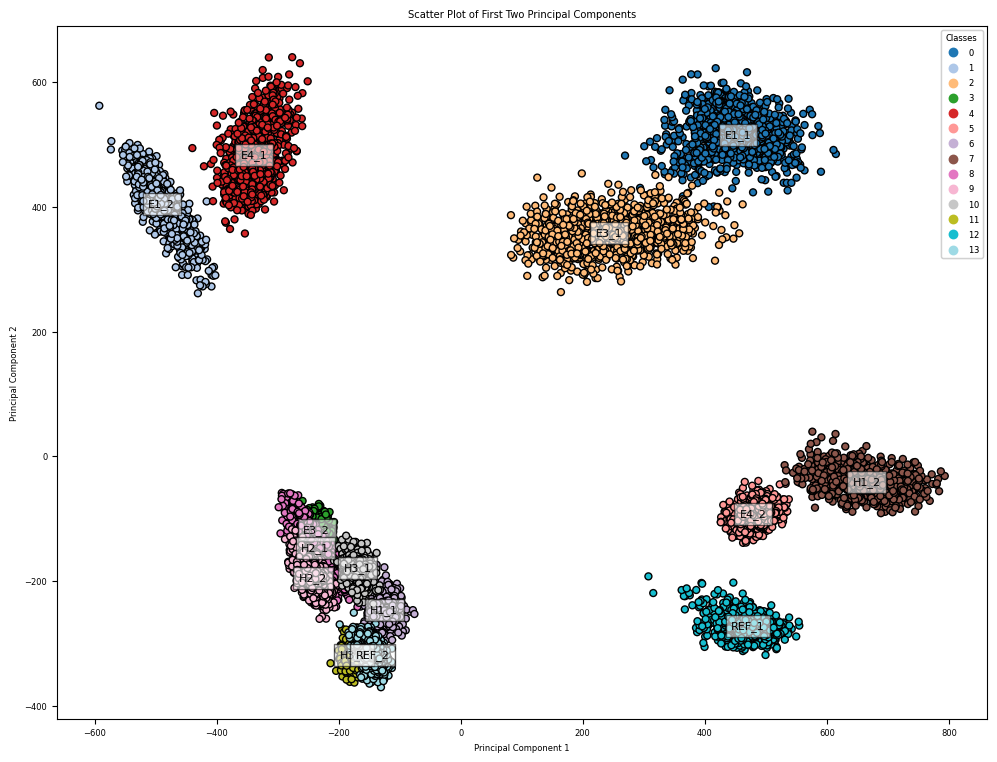

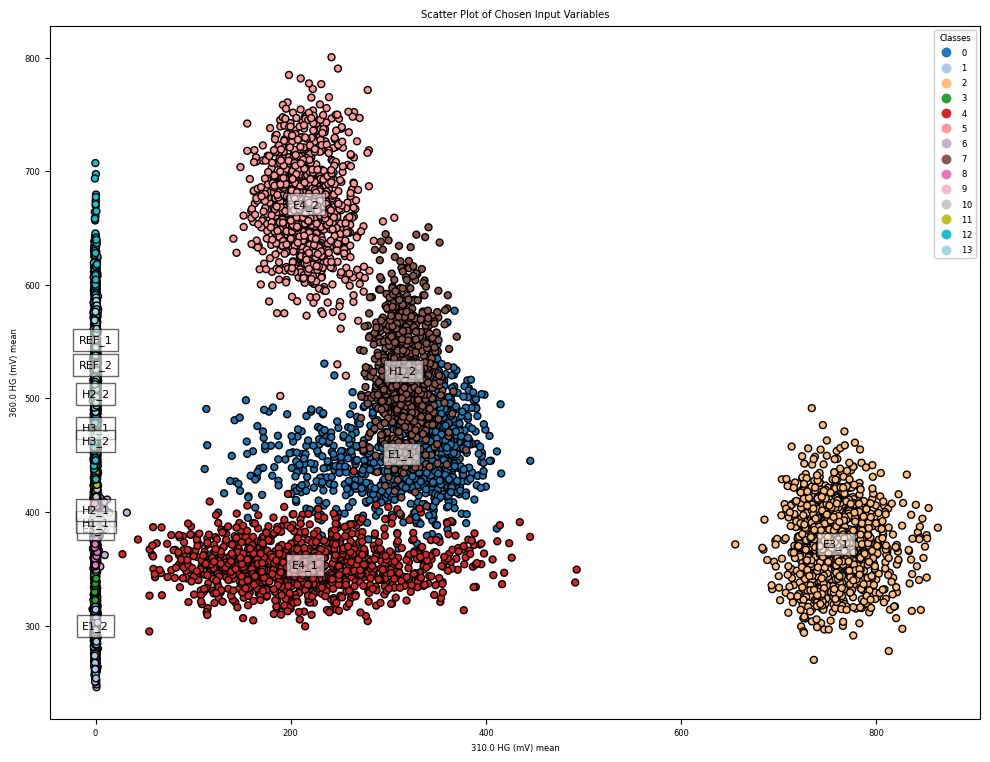

In [84]:
# Encode the labels
le = LabelEncoder()
y_new_sample_encoded = le.fit_transform(y_new_sample)

# Perform PCA
pca = PCA(n_components=2)
X_new_sample_pca = pca.fit_transform(X_new_sample)

# Create a DataFrame with the PCA components
components = pd.DataFrame(pca.components_, columns=X_new_sample.columns)
components = components.T

# Display the highest and lowest n variables of the first 3 components
n = 10
for i in range(pca.n_components_):
    print(f"Component {i+1}:")
    print(components[i].nlargest(n), '\n')
    print(components[i].nsmallest(n), '\n')

# Plot the PCA components (first two components for visualization)
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_new_sample_pca[:, 0], X_new_sample_pca[:, 1], c=y_new_sample_encoded, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0.1
unique_labels = np.unique(y_new_sample_encoded)
for i, label in enumerate(unique_labels):
    plt.text(X_new_sample_pca[y_new_sample_encoded == label][:, 0].mean(), 
             X_new_sample_pca[y_new_sample_encoded == label][:, 1].mean() + offset, 
             le.inverse_transform([label])[0], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of First Two Principal Components')

plt.show()


# Plot 2 input variables
var1 = '310.0 HG (mV)'
var2 = '360.0 HG (mV)'

var1 = '310.0 HG (mV) mean'
var2 = '360.0 HG (mV) mean'

plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_new_sample[var1], X_new_sample[var2], c=y_new_sample_encoded, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0.1
unique_labels = np.unique(y_new_sample_encoded)

for i, label in enumerate(unique_labels):
    plt.text(X_new_sample[y_new_sample_encoded == label][var1].mean(), 
             X_new_sample[y_new_sample_encoded == label][var2].mean() + offset, 
             le.inverse_transform([label])[0], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))
    
plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Scatter Plot of Chosen Input Variables')

plt.show()




In [78]:
result = permutation_importance(nb_model, X_new_sample, y_new_sample_encoded, n_repeats=5, random_state=seed, n_jobs=8)

# Preserve n most important features
n = 20
sorted_idx = result.importances_mean.argsort()[::-1][:n]  # Sort indices in descending order

plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

# Print n most important features from highest to lowest with their values
print("Permutation Importance:\n")
for i in sorted_idx:
    print(f"{X_new_sample.columns[i]}: {result.importances_mean[i]:.4f}")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- 210.0 HG (mV) std deviation
- 210.0 LG (mV) std deviation
- 250.0 HG (mV) std deviation
- 250.0 LG (mV) std deviation
- 270.0 HG (mV) std deviation
- ...


In [83]:
y_pred = rf_model.predict(X_new_sample, y_new_sample_encoded)
y_pred = nb_model.predict(X_new_sample, y_new_sample_encoded)
# y_pred = lr_model.predict(X_new_sample, y_new_sample_encoded)

# Calculate metrics
accuracy = accuracy_score(y_new_sample, y_pred)
precision = precision_score(y_new_sample, y_pred, average='weighted')
recall = recall_score(y_new_sample, y_pred, average='weighted')
f1 = f1_score(y_new_sample, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Convert the label encoded values back to the original class names
# y_new_sample = le.inverse_transform(y_new_sample)
# y_pred = le.inverse_transform(y_pred)

# Classification report
print(classification_report(le.inverse_transform(y_new_sample), le.inverse_transform(y_pred)), )

# Predictions made per class with its label encoded value
print(Counter(y_pred))

y_new_sample_encoded = le.inverse_transform(y_new_sample)
y_pred_encoded = le.inverse_transform(y_pred)

plot_confusion_matrix(y_new_sample_encoded, y_pred_encoded, le.classes_)

TypeError: ForestClassifier.predict() takes 2 positional arguments but 3 were given

In [183]:
# Load trained model
rf_model = joblib.load('random_forest_model.pkl')

# Predictions
y_pred = rf_model.predict(X_new_sample)



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- 100.0 HG (mV) mean
- 100.0 HG (mV) std deviation
- 100.0 LG (mV) mean
- 100.0 LG (mV) std deviation
- 110.0 HG (mV) mean
- ...


## Feature Importance TBD

## Labels

| Original Label | Encoded Value |
|----------------|---------------|
| A1             | 0             |
| B1             | 1             |
| C1             | 2             |
| D1             | 3             |
| E1             | 4             |
| F1             | 5             |
| G1             | 6             |
| H1             | 7             |
| I1             | 8             |
| J1             | 9             |
| K1             | 10            |
| L1             | 11            |
| M1             | 12            |
| N1             | 13            |
| REF            | 14            |